In [57]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import os
from time import sleep

import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import PIL.Image as Image

from dataset import *
from utilities import *
from resnet import *
from config import *

In [59]:
color_to_gray_map, gray_to_color_map = None, None

In [60]:
np.random.seed(0)
train_imageset_path = '../trainval/DAVIS/ImageSets/2017/train.txt'
val_imageset_path = '../trainval/DAVIS/ImageSets/2017/val.txt'
train_image_root = '../trainval/DAVIS/JPEGImages/480p/'
train_mask_root = '../trainval/DAVIS/Annotations/480p/'
testd_image_root = '../testd/DAVIS/JPEGImages/480p/'
testd_mask_root = '../testd/DAVIS/Annotations/480p/'
result_root = '../result/resnet/'
models_root = '../models/'

train_list = []
val_list = []

with open(train_imageset_path, 'r') as f:
    for line in f:
        train_list.append(line.strip())
with open(val_imageset_path, 'r') as f:
    for line in f:
        val_list.append(line.strip())


bear
type_cnt: 2
0.02830246463418007 0.992805325255102


/tmp/ipykernel_21062/55268610.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(loss.item(), torch.sum(output_mask == torch.tensor(input[:, 3, :, :]).to(device)).item() / (224 * 224))


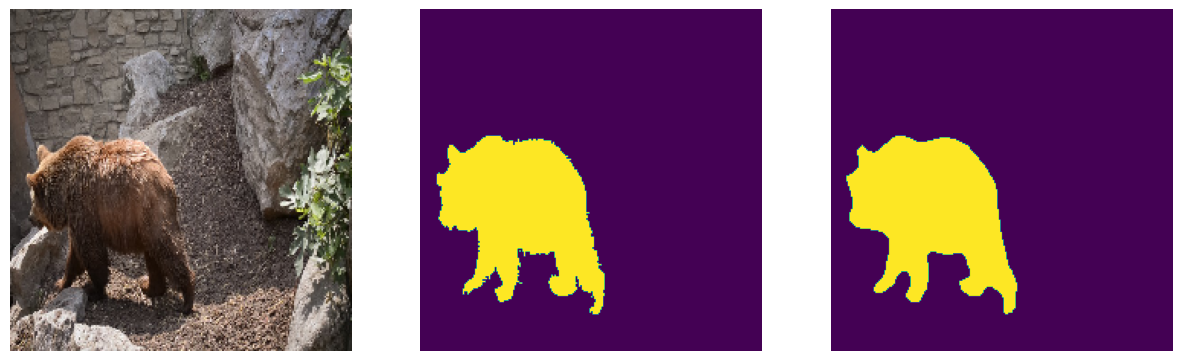

bmx-bumps
type_cnt: 3
boat
type_cnt: 2
0.046512383967638016 0.986945950255102


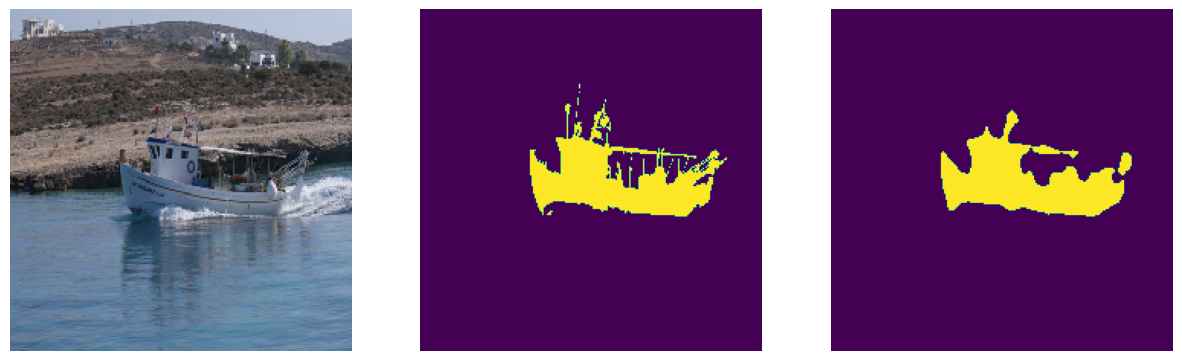

boxing-fisheye
type_cnt: 4
breakdance-flare
type_cnt: 2
0.02226324938237667 0.9943997130102041


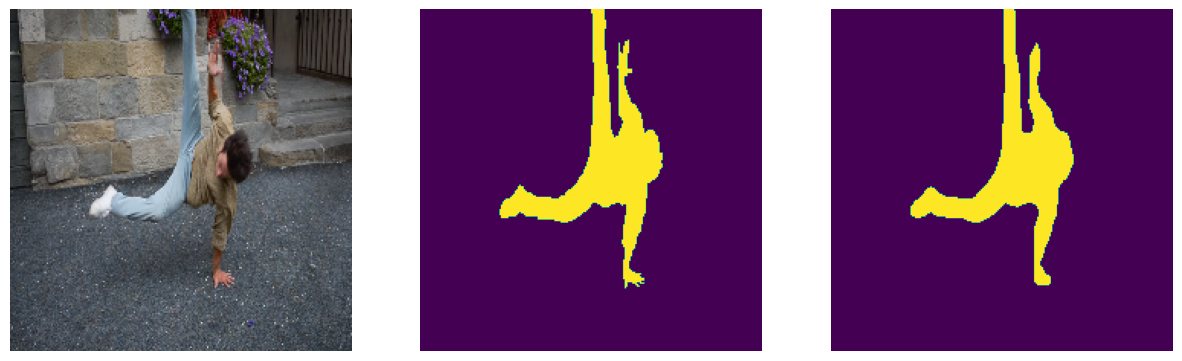

bus
type_cnt: 2
0.020219646394252777 0.9951769770408163


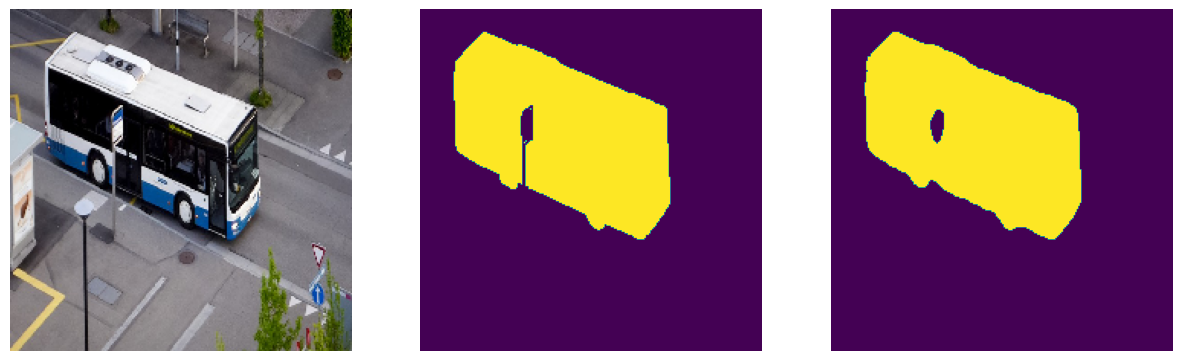

car-turn
type_cnt: 2
0.023803288117051125 0.9959741709183674


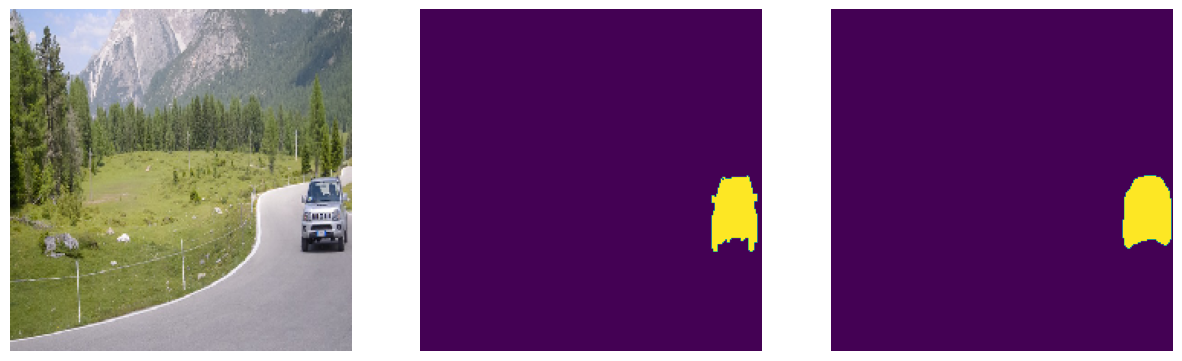

cat-girl
type_cnt: 3
classic-car
type_cnt: 4
color-run
type_cnt: 4
crossing
type_cnt: 4
dance-jump
type_cnt: 2
0.02382044494152069 0.9935626594387755


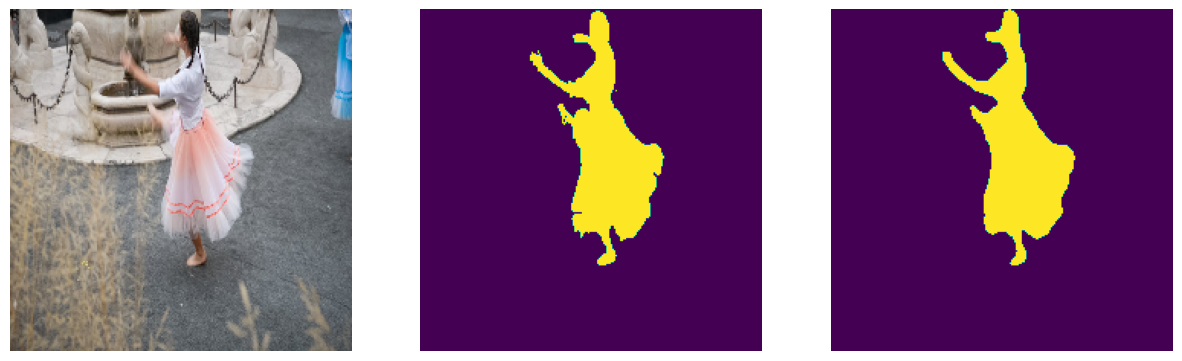

dancing
type_cnt: 4
disc-jockey
type_cnt: 4
dog-agility
type_cnt: 2
0.03121555596590042 0.9900151466836735


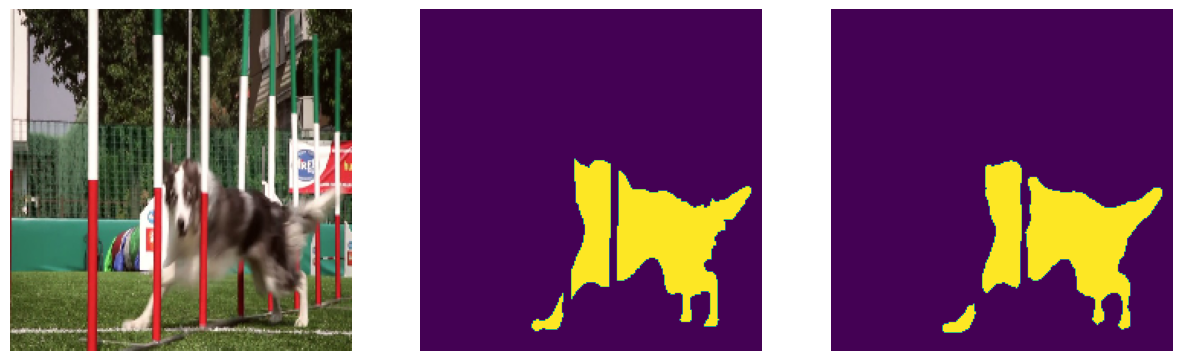

dog-gooses
type_cnt: 6
dogs-scale
type_cnt: 5
drift-turn
type_cnt: 2
0.02068493328988552 0.9980070153061225


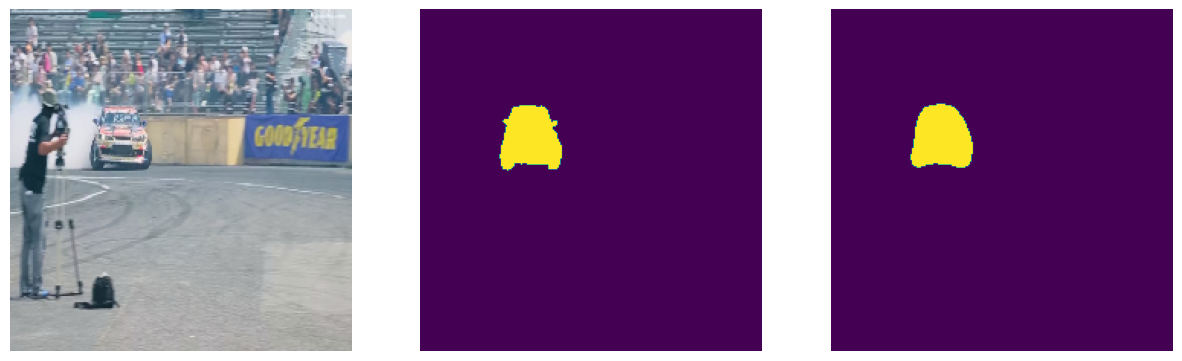

drone
type_cnt: 6
elephant
type_cnt: 2
0.02895410731434822 0.9923668686224489


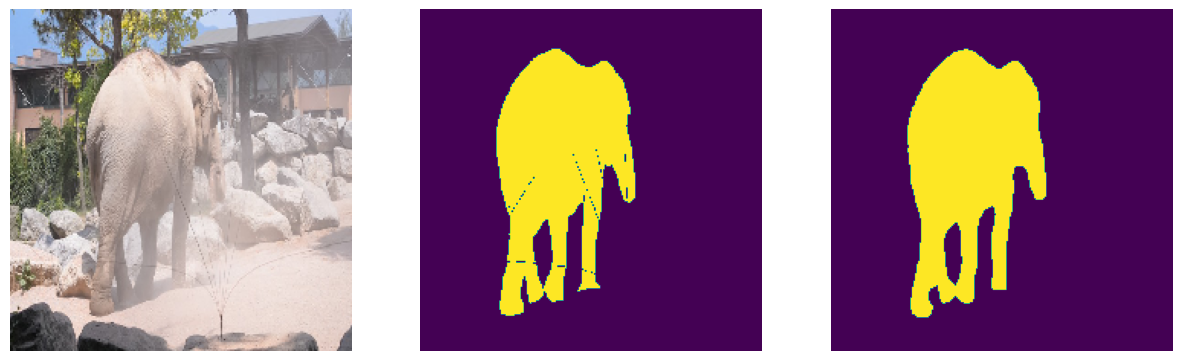

flamingo
type_cnt: 2
0.03356665372848511 0.9901147959183674


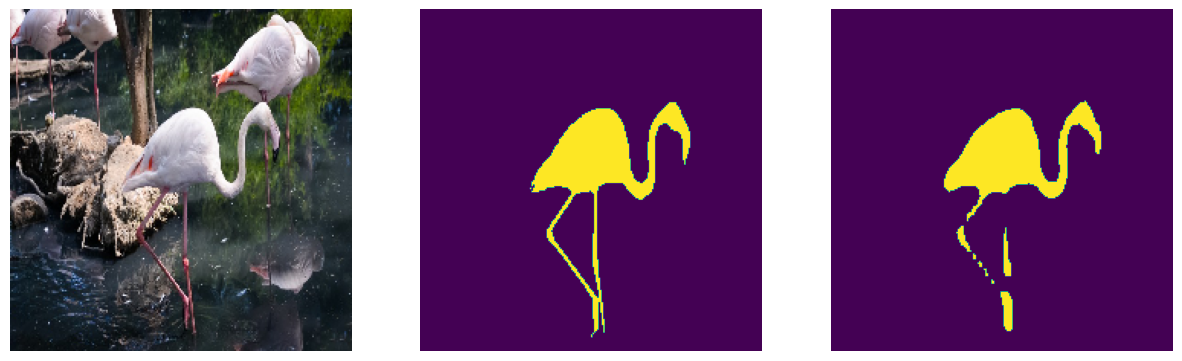

hike
type_cnt: 2
0.028349619358778 0.9948381696428571


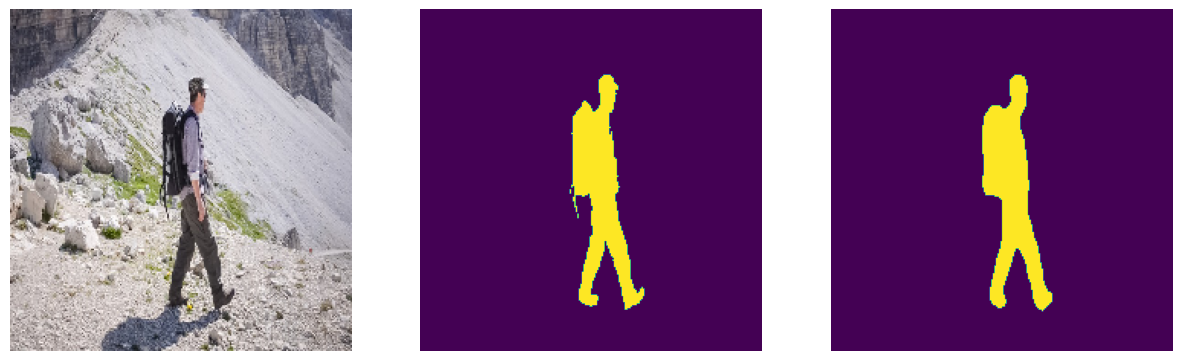

hockey
type_cnt: 4
horsejump-low
type_cnt: 3
kid-football
type_cnt: 3
kite-walk
type_cnt: 4
koala
type_cnt: 2
0.02649649977684021 0.9902144451530612


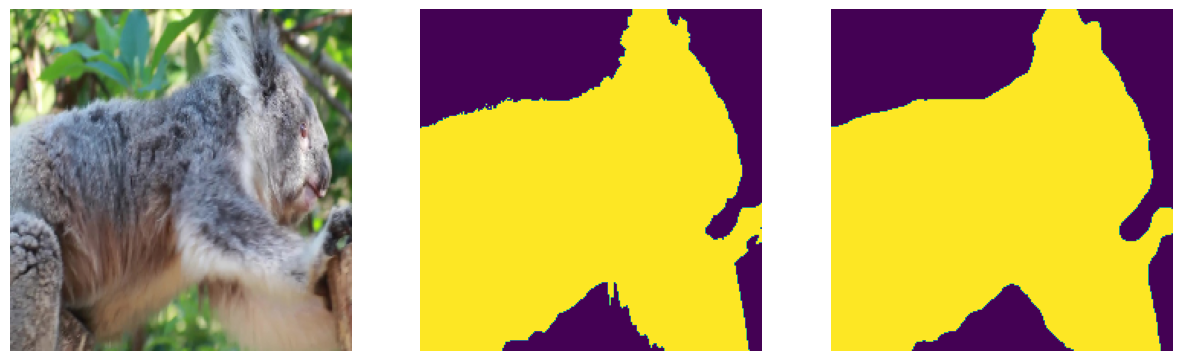

lady-running
type_cnt: 3
lindy-hop
type_cnt: 9
longboard
type_cnt: 6
lucia
type_cnt: 2
0.026336902752518654 0.9937220982142857


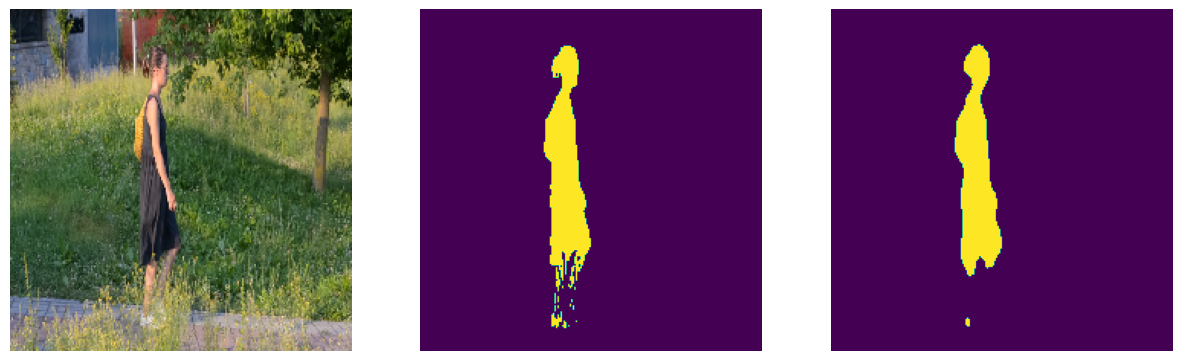

mallard-fly
type_cnt: 2
0.019804827868938446 0.9963329081632653


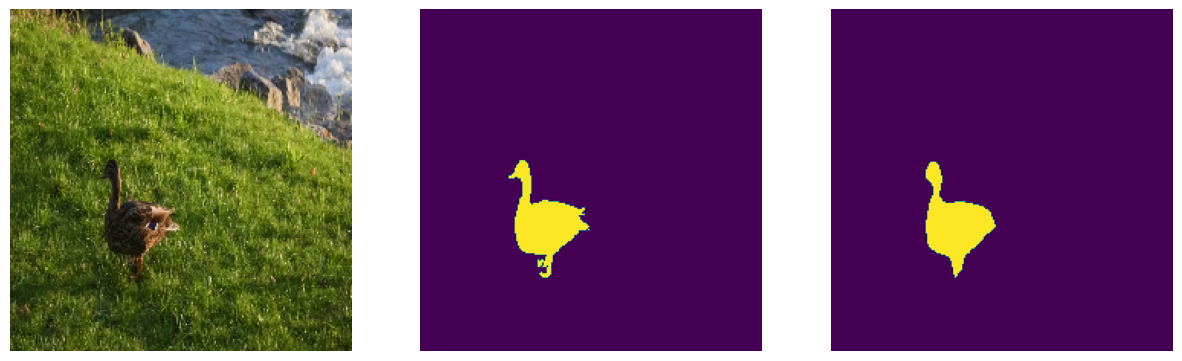

mallard-water
type_cnt: 2
0.0185445137321949 0.9957948022959183


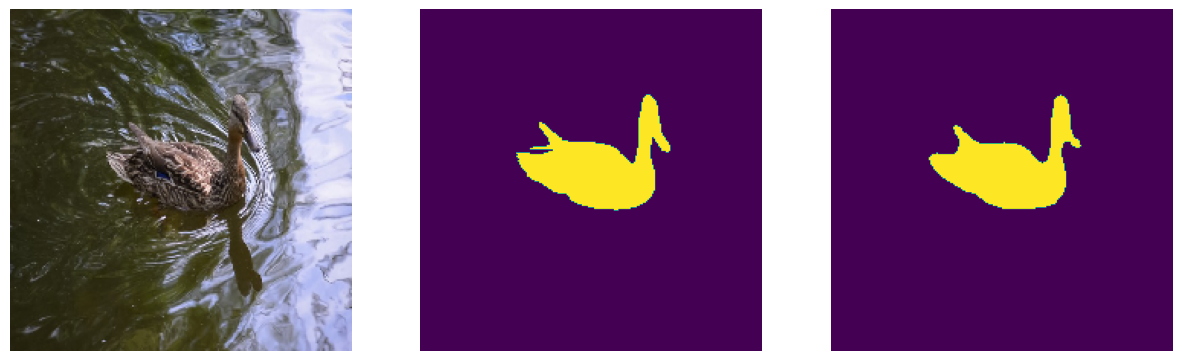

miami-surf
type_cnt: 7
motocross-bumps
type_cnt: 3
motorbike
type_cnt: 4
night-race
type_cnt: 3
paragliding
type_cnt: 3
planes-water
type_cnt: 3
rallye
type_cnt: 2
0.019942421466112137 0.9995216836734694


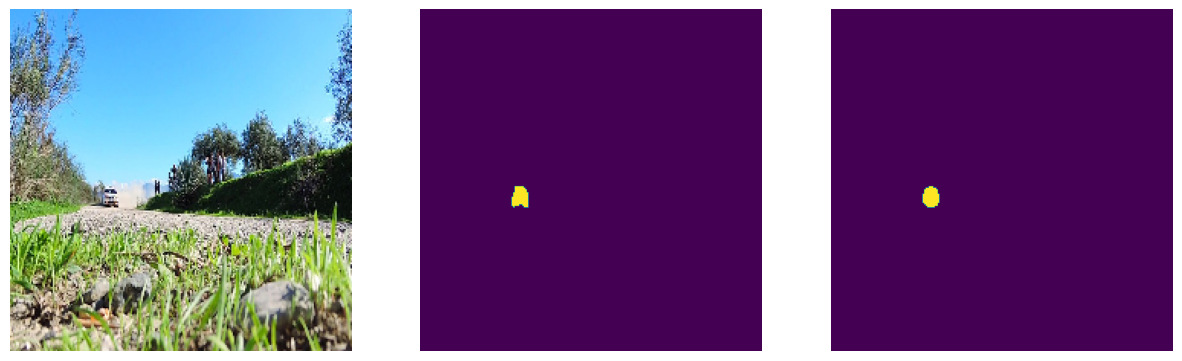

rhino
type_cnt: 2
0.02629736438393593 0.9909717793367347


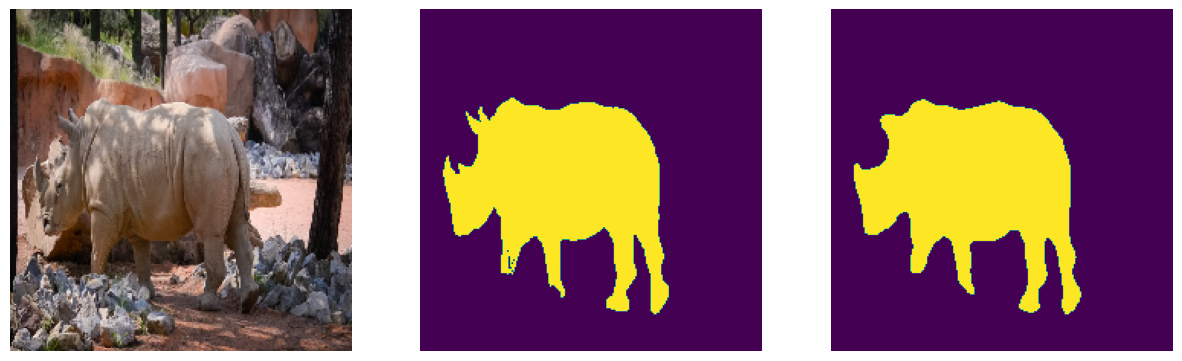

rollerblade
type_cnt: 2
0.016985923051834106 0.9964126275510204


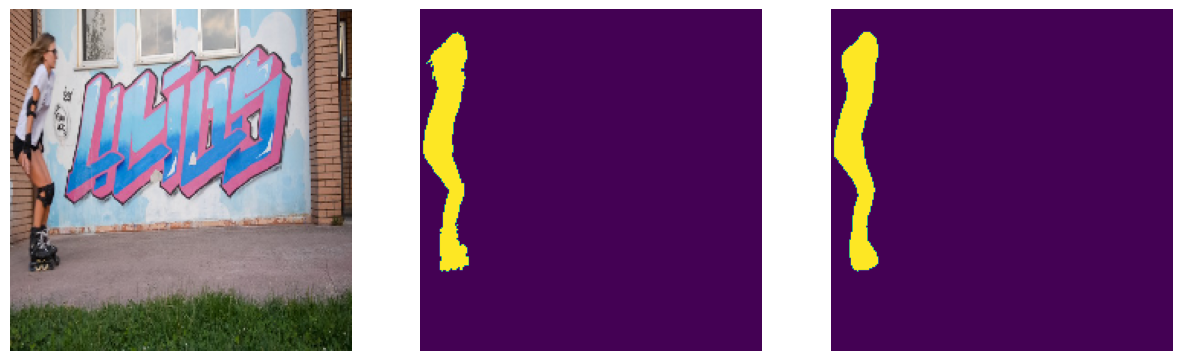

schoolgirls
type_cnt: 8
scooter-board
type_cnt: 3
scooter-gray
type_cnt: 3
sheep
type_cnt: 6
skate-park
type_cnt: 3
snowboard
type_cnt: 3
soccerball
type_cnt: 2
0.017155999317765236 0.9984853316326531


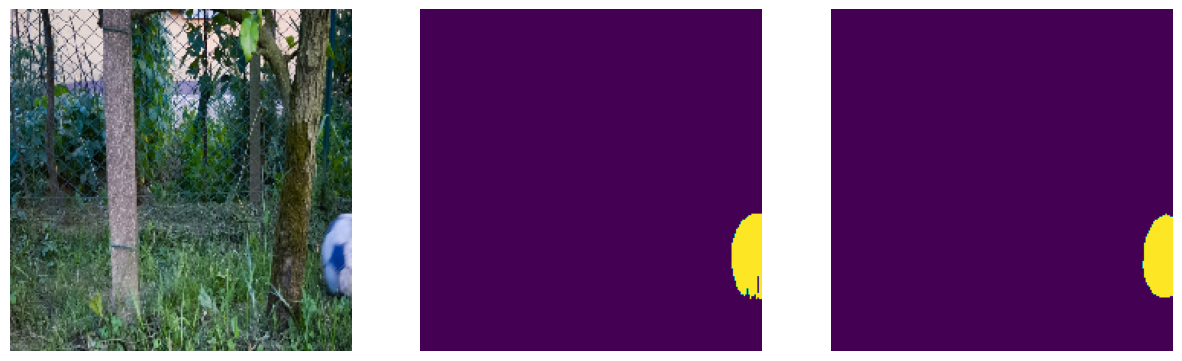

stroller
type_cnt: 3
stunt
type_cnt: 3
surf
type_cnt: 4
swing
type_cnt: 4
tennis
type_cnt: 3
tractor-sand
type_cnt: 4
train
type_cnt: 5
tuk-tuk
type_cnt: 4
upside-down
type_cnt: 3
varanus-cage
type_cnt: 2
0.022356197237968445 0.9948780293367347


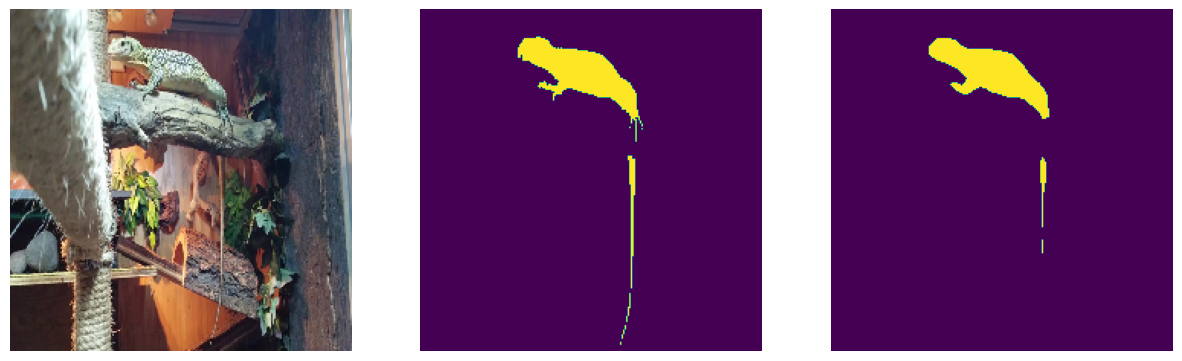

walking
type_cnt: 3


In [61]:
for i in range(len(train_list)):
    
    print(train_list[i])
    image_path = os.path.join(train_image_root, train_list[i] + '/00000.jpg')
    mask_path = os.path.join(train_mask_root, train_list[i] + '/00000.png')
    result_path = os.path.join(result_root, train_list[i])
    model_save_path = os.path.join(models_root, train_list[i] + '.pt')

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)

    image = cv2.resize(image, (resize, resize), interpolation=cv2.INTER_NEAREST)
    mask = cv2.resize(mask, (resize, resize), interpolation=cv2.INTER_NEAREST)
    mask, color_to_gray_map, gray_to_color_map = convert_to_gray_mask(mask)
    print('type_cnt:', len(color_to_gray_map))
    
    if len(color_to_gray_map) > 2:
        continue

    val_dataset = CustomDataset(image_path, mask_path, image_transform=val_image_transforms, mask_transform=val_mask_transforms, num_samples=1)
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = MyResNet(len(color_to_gray_map)).to(device)
    model.load_state_dict(torch.load(model_save_path))

    model.eval()
    for image, mask in val_dataloader:
        
        mask = (mask * 255).long()
        input = torch.cat((image, mask), dim=1).to(device)
        output_mask = torch.argmax(model(input), dim=1)
        output = model(input)
        loss = F.cross_entropy(output, input[:, 3, :, :].long())
        print(loss.item(), torch.sum(output_mask == torch.tensor(input[:, 3, :, :]).to(device)).item() / (224 * 224))
        
        mask_np = mask.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        output_mask_np = output_mask.cpu().numpy().transpose(1, 2, 0)
        image_np = image.squeeze(0).numpy().transpose(1, 2, 0)
        print_images([image_np, mask_np, output_mask_np])
